In [42]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools
from IPython.display import Image

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import adjusted_rand_score, rand_score

from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Introduction
In this project I have chosen to select a classification problem from the UCI Machine Learning Repository.  The link to the specific dataset can be found here: https://archive.ics.uci.edu/ml/datasets/seeds  (formal citation at end of report)  
This dataset examines seeds (kernels) belonging to three different wheat strains, each randomly selected.  There are 70 samples of each strain for a total of 210 samples in the dataset.  The attributes provided are as follows:  
Area of Kernel (float)  
Perimeter of Kernel (float)  
Compactness of Kernel (float, constructed from area and perimeter)  
Length of Kernel (float)  
Width of Kernel (float)  
Asymmetry Coefficient of Kernel (float)  
Length of Kernel Groove (float)  
Type of Kernel (Presented as float, truly categorical)  
# The Goal  
The goal of this project is to be able to cluster a given kernel in to a grouping of the same strain of wheat based upon these characteristics.  The dimensions are easy and cheap to automatically record and as such an algorithm which can take in these raw numbers and return a classification is quite useful for commercial purposes if the basic idea here can be expanded upon.  
We will first clean and examine the data, then we will perform an unsupervised approach to which we will finally compare a supervised approach.  We end up using KMeans for our unsupervised and a linear SVC for our supervised approaches.  
The models used were chosen based primarily upon the following resource: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html  
Because of the small size of our data we are not constrained by time complexity, but both of the methods chosen are suitable for scaling up which will be discussed a bit more in the conclusion.  
In the interest of saving space I will not detail all of the reasonings for my choices in this notebook but will rather discuss it in the video portion of this assignment.

# Data Reading and Cleaning

In [2]:
#Read in data
data = pd.read_csv('Data\seeds.txt', header = None, sep = '\t', lineterminator='\n', 
                   names = ['Area', 'Perimeter', 'Compactness', 'Length', 'Width', 'Asymmetry', 'Groove', 'Type'],
                  index_col = False)

In [3]:
#check data head
data.head()

,Area,Perimeter,Compactness,Length,Width,Asymmetry,Groove,Type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1.0
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1.0
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1.0
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1.0
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1.0


In [41]:
data.shape #shape of full dataset- 210 rows, 7 features, 1 target.

(210, 8)

Compactness is given as C = 4*pi*A/P^2 and as such is constructed from two of our other predictors.  
'Groove' column is the length of the kernel's groove  
'Type' column is truly categorical, 1 == Kama, 2 == Rosa, 3 == Canadian, though the specific strains won't matter here.

In [4]:
data.iloc[7] #keep this in and post a picture of the data below to show what happened, write a short summary paragraph to explain it too

Area           14.1100
Perimeter      14.1000
Compactness     0.8911
Length          5.4200
Width           3.3020
Asymmetry       2.7000
Groove             NaN
Type            5.0000
Name: 7, dtype: float64

In [5]:
data[(data.Type != 1) & (data.Type != 2) & (data.Type != 3)] #to help id the points where the data was misplaced at first, can confirm visually with the data itself

,Area,Perimeter,Compactness,Length,Width,Asymmetry,Groove,Type
7,14.11,14.10,0.8911,5.4200,3.302,2.700,NaN,5.000
35,16.12,15.00,NaN,0.9000,NaN,5.709,3.485,2.270
60,11.42,12.86,0.8683,5.0080,2.850,2.700,NaN,4.607
68,14.37,14.39,0.8726,5.5690,3.153,1.464,5.300,NaN
106,18.85,16.17,0.9056,6.1520,3.806,2.843,6.200,NaN
135,15.38,14.66,0.8990,5.4770,3.465,3.600,NaN,5.439
169,11.24,13.00,NaN,0.8359,5.090,2.715,3.521,5.088
170,11.02,13.00,NaN,0.8189,5.325,2.701,6.735,5.163
172,11.27,12.97,0.8419,5.0880,2.763,4.309,5.000,NaN
201,12.67,13.32,0.8977,4.9840,3.135,2.300,NaN,4.745


Only 11 spots where it seems the data was malformed, could just toss them but it would be easy enough to manually fix this many so we shall do so.  
Below I've displayed an image showing an example of how the dataset is distorted.  Hard for a computer to read but not hard for us to fix manually!

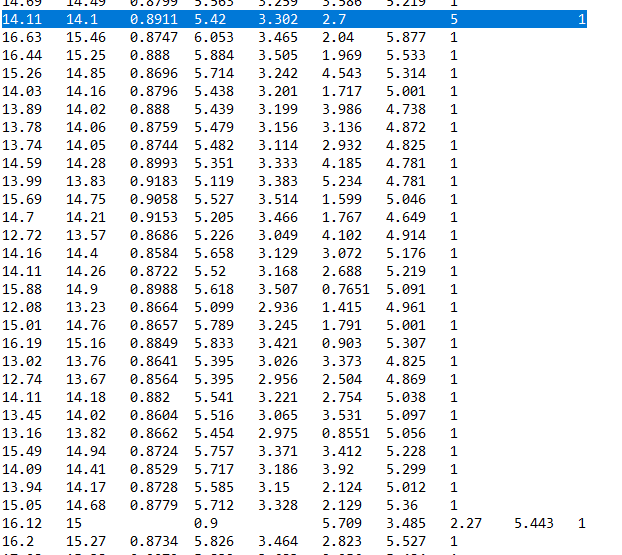

In [45]:
#iloc[7] at top
Image('Data/data_image.png')

In [6]:
true_7 = [14.11, 14.1, 0.8911, 5.42, 3.302, 2.7, 5.0, 1]
true_35 = [16.12, 15, 0.9, 5.709, 3.485, 2.27, 5.443, 1]
true_60 = [11.42, 12.86, 0.8683, 5.008, 2.85, 2.7, 4.607, 1]
true_68 = [14.37, 14.39, 0.8726, 5.569, 3.153, 1.464, 5.3, 1]
true_106 = [18.85, 16.17, 0.9056, 6.152, 3.806, 2.843, 6.2, 2]
true_135 = [15.38, 14.66, 0.899, 5.477, 3.465, 3.6, 5.439, 2]
true_169 = [11.24, 13, 0.8359, 5.09, 2.715, 3.521, 5.088, 3]
true_170 = [11.02, 13, 0.8189, 5.325, 2.701, 6.735, 5.163, 3]
true_172 = [11.27, 12.97, 0.8419, 5.088, 2.763, 4.309, 5, 3]
true_201 = [12.67, 13.32, 0.8977, 4.984, 3.135, 2.3, 4.745, 3]
true_203 = [12.7, 13.41, 0.8874, 5.183, 3.091, 8.456, 5, 3]

# print(len(true_7),len(true_35),len(true_60),len(true_68),len(true_106),len(true_135),len(true_169),len(true_170),len(true_172),len(true_201), len(true_203)) #all 8's, matches with data, seems good!

In [7]:
#replace each point by the true values
data.loc[7] = true_7
data.loc[35] = true_35
data.loc[60] = true_60
data.loc[68] = true_68
data.loc[106] = true_106
data.loc[135] = true_135
data.loc[169] = true_169
data.loc[170] = true_170
data.loc[172] = true_172
data.loc[201] = true_201
data.loc[203] = true_203

In [8]:
data[(data.Type != 1) & (data.Type != 2) & (data.Type != 3)] #make sure no more misclassified points/kernels exist

,Area,Perimeter,Compactness,Length,Width,Asymmetry,Groove,Type


In [33]:
# data.to_csv("Data\seeds_clean", header = None, sep = '\t')
#save data to new csv keeping it tab seperated, can use more easily in the future

# EDA  
Note that the features were described earlier in the Introduction section

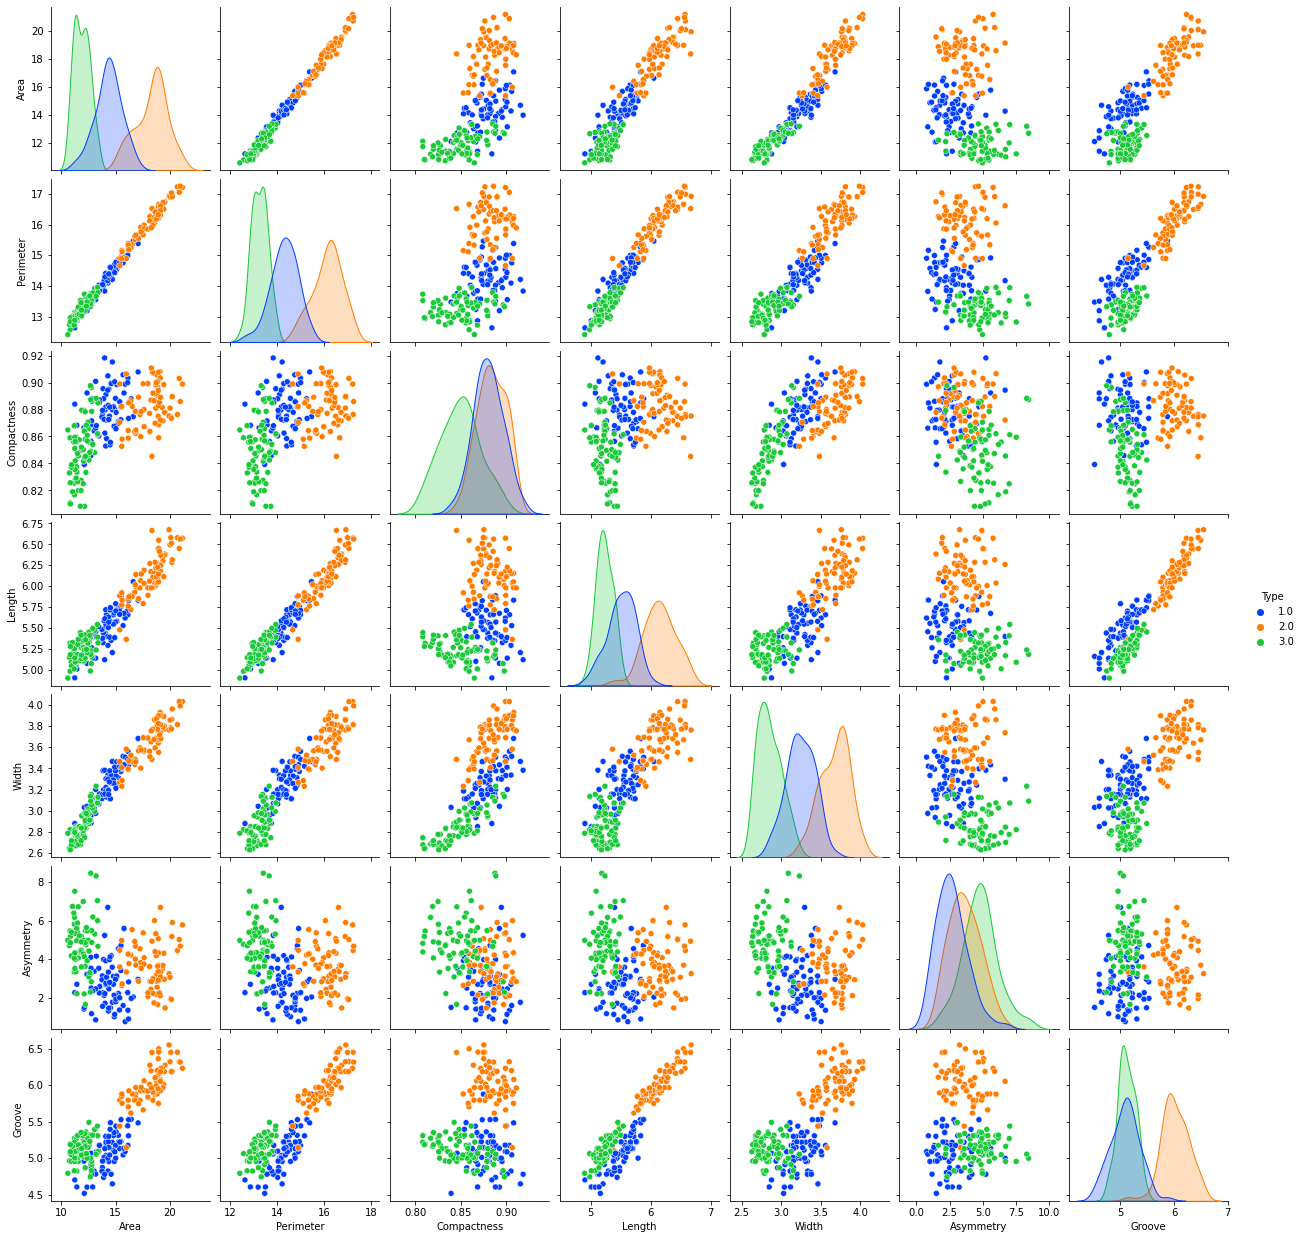

In [9]:
#Below pairplot gives lots of warnings saying  UserWarning: Dataset has 0 variance; skipping density estimate.warnings.warn(msg, UserWarning) which we will suppress for now
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sns.pairplot(data, hue = 'Type', palette = 'bright')

Can see the groups are fairly easily split in some of these, but relatively overlapping in others.  Helps us to decide which attributes are most important for our clustering if we wanted to go that route.  But first let us remove the target column and try a minibatch kmeans clustering solution using all the data except the true labels.  No obvious outliers.

In [10]:
#examine correlation matrix
corr_mtx = data.drop('Type', axis = 1).corr()
corr_mtx.style.background_gradient(cmap = 'coolwarm')

,Area,Perimeter,Compactness,Length,Width,Asymmetry,Groove
Area,1.000000,0.994341,0.608288,0.949985,0.970771,-0.229572,0.863693
Perimeter,0.994341,1.000000,0.529244,0.972422,0.944829,-0.217340,0.890784
Compactness,0.608288,0.529244,1.000000,0.367915,0.761635,-0.331471,0.226825
Length,0.949985,0.972422,0.367915,1.000000,0.860415,-0.171562,0.932806
Width,0.970771,0.944829,0.761635,0.860415,1.000000,-0.258037,0.749131
Asymmetry,-0.229572,-0.217340,-0.331471,-0.171562,-0.258037,1.000000,-0.011079
Groove,0.863693,0.890784,0.226825,0.932806,0.749131,-0.011079,1.000000


Obviously there is quite a bit of correlation in our features.  PCA will probably be quite useful here.  
Also we may not necessarily need, but will use a scaler as it is unclear if all of these features are on a similar enough scale to forgo such a treatment.

# Unsupervised Approach 1 (Splitting Data For Comparison)

In [11]:
#Split off our true labels for later testing
y_full = data.Type
X_full = data.drop('Type', axis = 1)
#split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size = 0.2, random_state = 54322)

In [12]:
#Find the number of features required to get to 95% explained varience
#init methods
scaler = StandardScaler()
pca = PCA()
#scale our training data
X_train_scaled = scaler.fit_transform(X_train)
#perform PCA
X_pca = pca.fit_transform(X_train_scaled)
#show the total explained variance
tot_exp_var = pca.explained_variance_ratio_.cumsum()
#find number of features required to get up to or over 95% explained variance
n_95 = len(tot_exp_var[tot_exp_var >= 0.95])
n_to_95 = X_full.shape[1] - n_95 + 1
print(f"Number of features required to get up to or over 95% explained variance is {n_to_95} giving {round(tot_exp_var[n_to_95 - 1],4)*100}% variance.")

Number of features required to get up to or over 95% explained variance is 3 giving 98.66% variance.


We already know apriori that 3 is the proper number of clusters to have, but this code would serve us well if there was ever a question as to what k we should select or if the number of strains of wheat were to be expanded.  As for now it simply confirms that 3 is the correct choice based on the bend of our elbow plot and is left in for completeness.

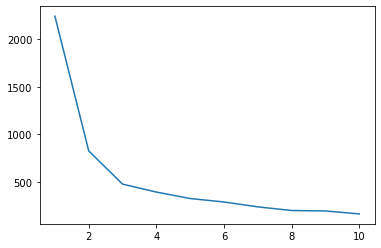

In [13]:
bucket = []
for k_val in range(1,11):
    kmeans = MiniBatchKMeans(n_clusters = k_val, random_state = 54322)
    kmeans.fit(X_train)
    bucket.append(kmeans.inertia_)
plt.plot(np.arange(1,11), bucket)

In [14]:
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components = n_to_95)), ('clf', MiniBatchKMeans(random_state = 5, n_clusters=3))])
pipe.fit(X_train)
y_pred = pipe.predict(X_test)

In [15]:
def predorder(pred, true, k_val = 3):
    """
    Returns the predicted KMeans values ordered in the way that gives the highest accuracy
    k_val defaults to 3 since that's all we're using here but allows for future growth if needed
    """
    temp = None
    bucket = []
    for combo in itertools.permutations(np.arange(1,k_val+1)):
#         print(combo)
        relabel = np.choose(pred, combo).astype(float) 
#         print(relabel)
#         print(list(true))
        acc_val = np.mean(relabel == list(true))
        bucket.append(acc_val)
#         print(acc_val)
        if (len(bucket) == 0) or (acc_val >= max(bucket)):
            temp = relabel
        else:
            continue
    return temp

In [16]:
#re-init print statements to show the orders tested and the accuracies that they would give, still just returns the properly ordered labels
ordered_pred = predorder(y_pred, y_test, 3)
print(f"highest acc score: {round(np.mean(ordered_pred == y_test),4)}") #accuracy value
print(f"rand score: {round(rand_score(y_test, ordered_pred), 4)}, adjusted rand score: {round(adjusted_rand_score(y_test, ordered_pred),4)}")

highest acc score: 0.9286
rand score: 0.9036, adjusted rand score: 0.7814


Fully unsupervised and with minimal tweaking we get an accuracy of almost 93%.  Using more clustering-friendly metrics for evaluation we see a rand score of over 0.9 and an adjusted rand score of around 78%.  Quite good results! Lets do some plotting to compare these visually. 

<ipython-input-17-aa6b6fd54b41>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Predicted'] = ordered_pred


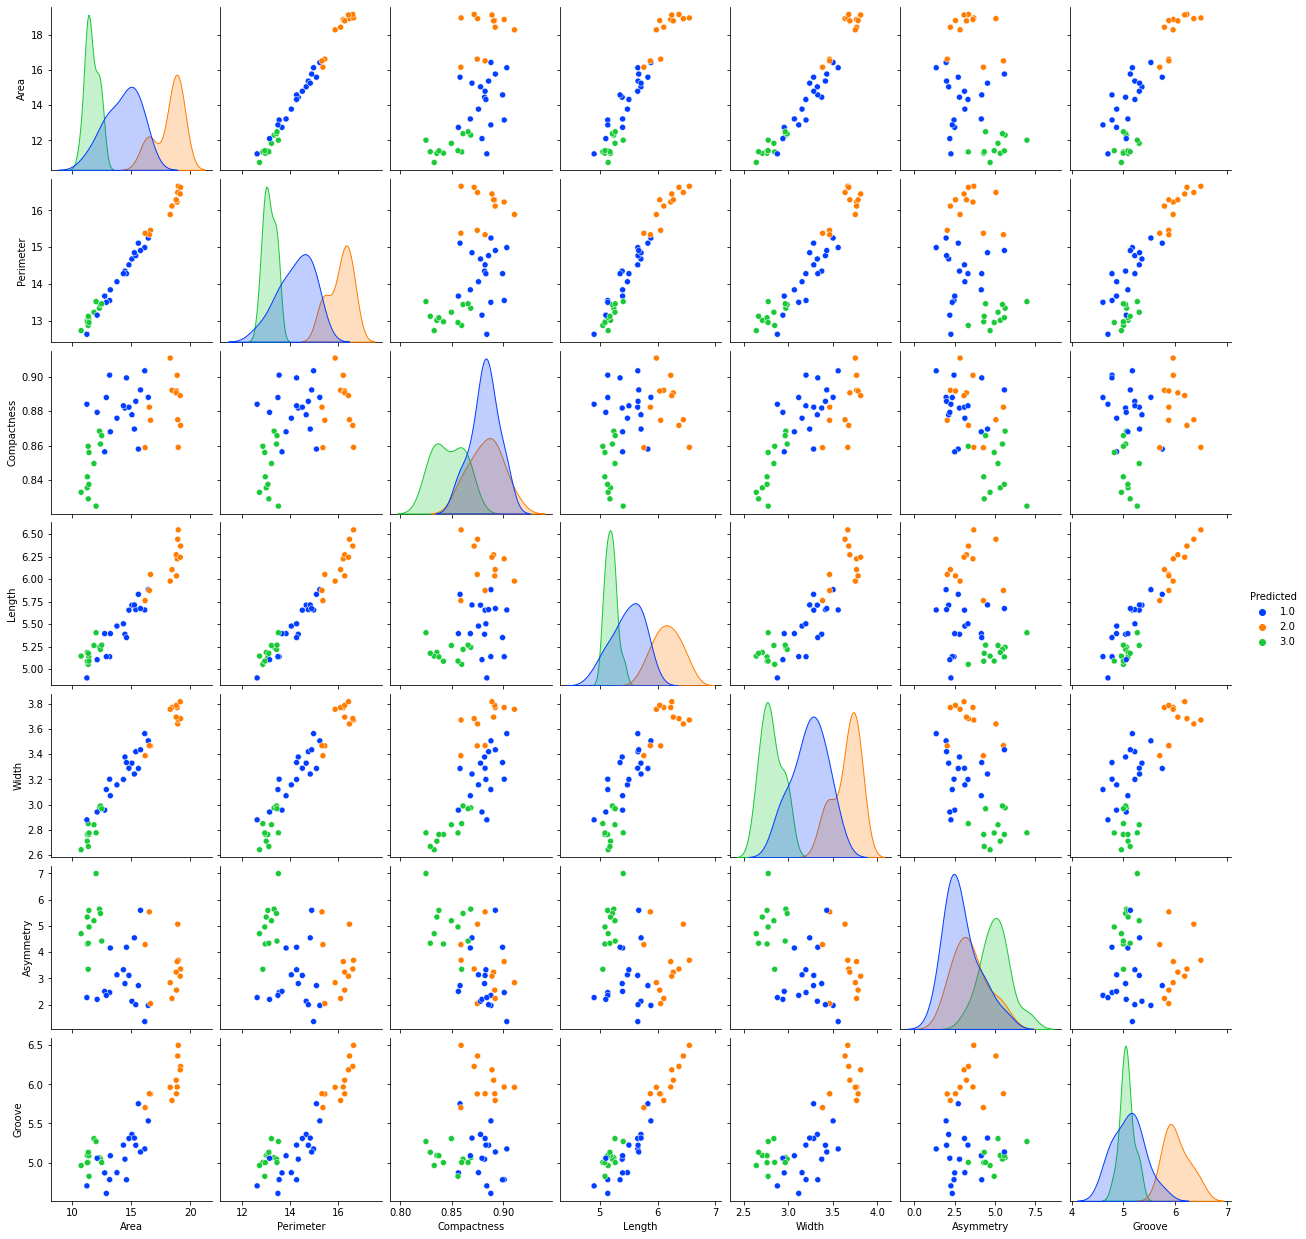

In [17]:
X_test['Predicted'] = ordered_pred
sns.pairplot(X_test, hue = 'Predicted', palette = 'bright')

[Text(0.5, 1.0, 'Predicted')]

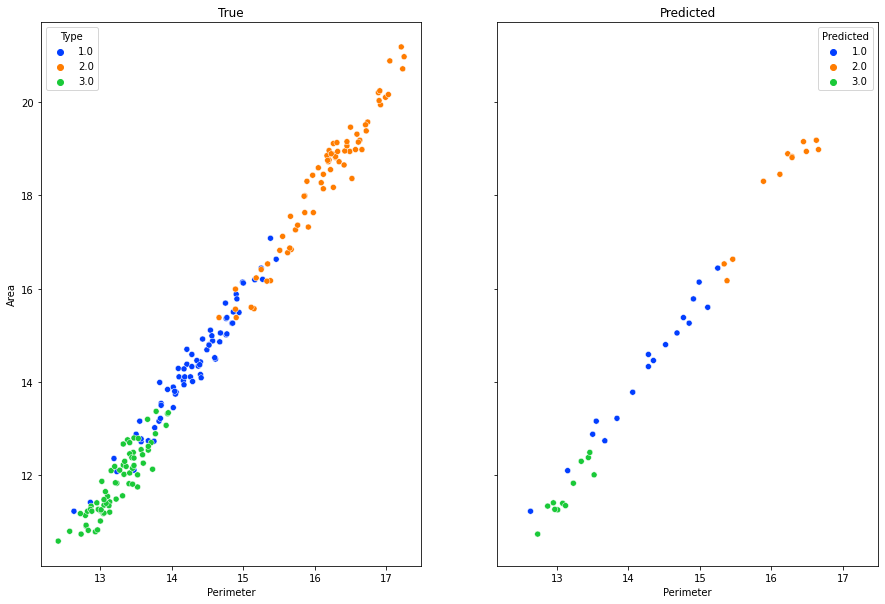

In [18]:
#Permieter and Area had a nice seperation from our ground-truth pairplot, use this for illistrative purposes here
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (15,10), sharex = True, sharey = True)
sns.scatterplot(data = data, y = "Area", x = "Perimeter", hue = 'Type', palette = 'bright', ax = ax1).set(title = "True")
sns.scatterplot(data = X_test, y = "Area", x = "Perimeter", hue = 'Predicted', palette = 'bright', ax = ax2).set(title = "Predicted")

[Text(0.5, 1.0, 'Predicted')]

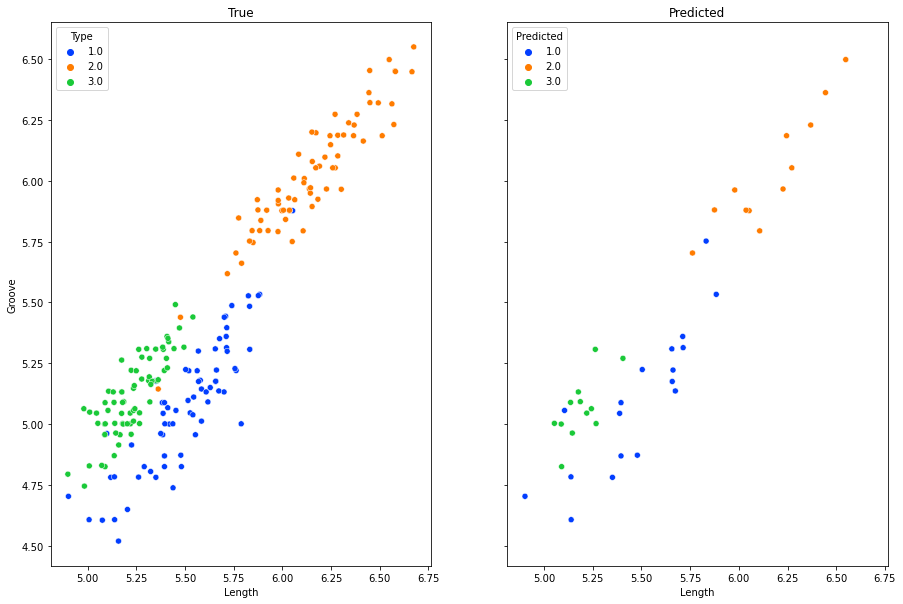

In [19]:
#Similarly can show it with Length and Groove
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (15,10), sharex = True, sharey = True)
sns.scatterplot(data = data, y = "Groove", x = "Length", hue = 'Type', palette = 'bright', ax = ax1).set(title = "True")
sns.scatterplot(data = X_test, y = "Groove", x = "Length", hue = 'Predicted', palette = 'bright', ax = ax2).set(title = "Predicted")

# Unsupervised, Full Dataset
Since it is an unsupervised approach we can justifiably use the full dataset.  The above is kept to more directly compare to our supervised approach but all three results will be displayed in the conclusion.

In [20]:
#Find the number of features required to get to 95% explained varience
#init methods
scaler = StandardScaler()
pca = PCA()
#scale our training data
X_full_scaled = scaler.fit_transform(X_full)
#perform PCA
X_pca_full = pca.fit_transform(X_full_scaled)
#show the total explained variance
tot_exp_var_full = pca.explained_variance_ratio_.cumsum()
#find number of features required to get up to or over 95% explained variance
n_95_full = len(tot_exp_var_full[tot_exp_var_full >= 0.95])
n_to_95_full = X_full.shape[1] - n_95 + 1
print(f"Number of features required to get up to or over 95% explained variance is {n_to_95_full} giving {round(tot_exp_var_full[n_to_95 - 1],4)*100}% variance.")

Number of features required to get up to or over 95% explained variance is 3 giving 98.67% variance.


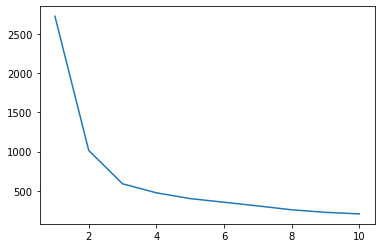

In [21]:
bucket = []
for k_val in range(1,11):
    kmeans = MiniBatchKMeans(n_clusters = k_val, random_state = 54322)
    kmeans.fit(X_full)
    bucket.append(kmeans.inertia_)
plt.plot(np.arange(1,11), bucket)

Again see elbow at K=3

In [34]:
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components = n_to_95_full)), ('clf', MiniBatchKMeans(random_state = 5432, n_clusters=3))])
pipe.fit(X_full)
y_pred_full = pipe.predict(X_full)

In [35]:
#re-init print statements to show the orders tested and the accuracies that they would give, still just returns the properly ordered labels
ordered_pred_full = predorder(y_pred_full, y_full, 3)
print(f"highest acc score (full dataset): {round(np.mean(ordered_pred_full == y_full),4)}") #accuracy value
print(f"rand score (full dataset): {round(rand_score(y_full, ordered_pred_full), 4)}, adjusted rand score (full dataset): {round(adjusted_rand_score(y_full, ordered_pred_full),4)}")


highest acc score (full dataset): 0.9238
rand score (full dataset): 0.9053, adjusted rand score (full dataset): 0.7861


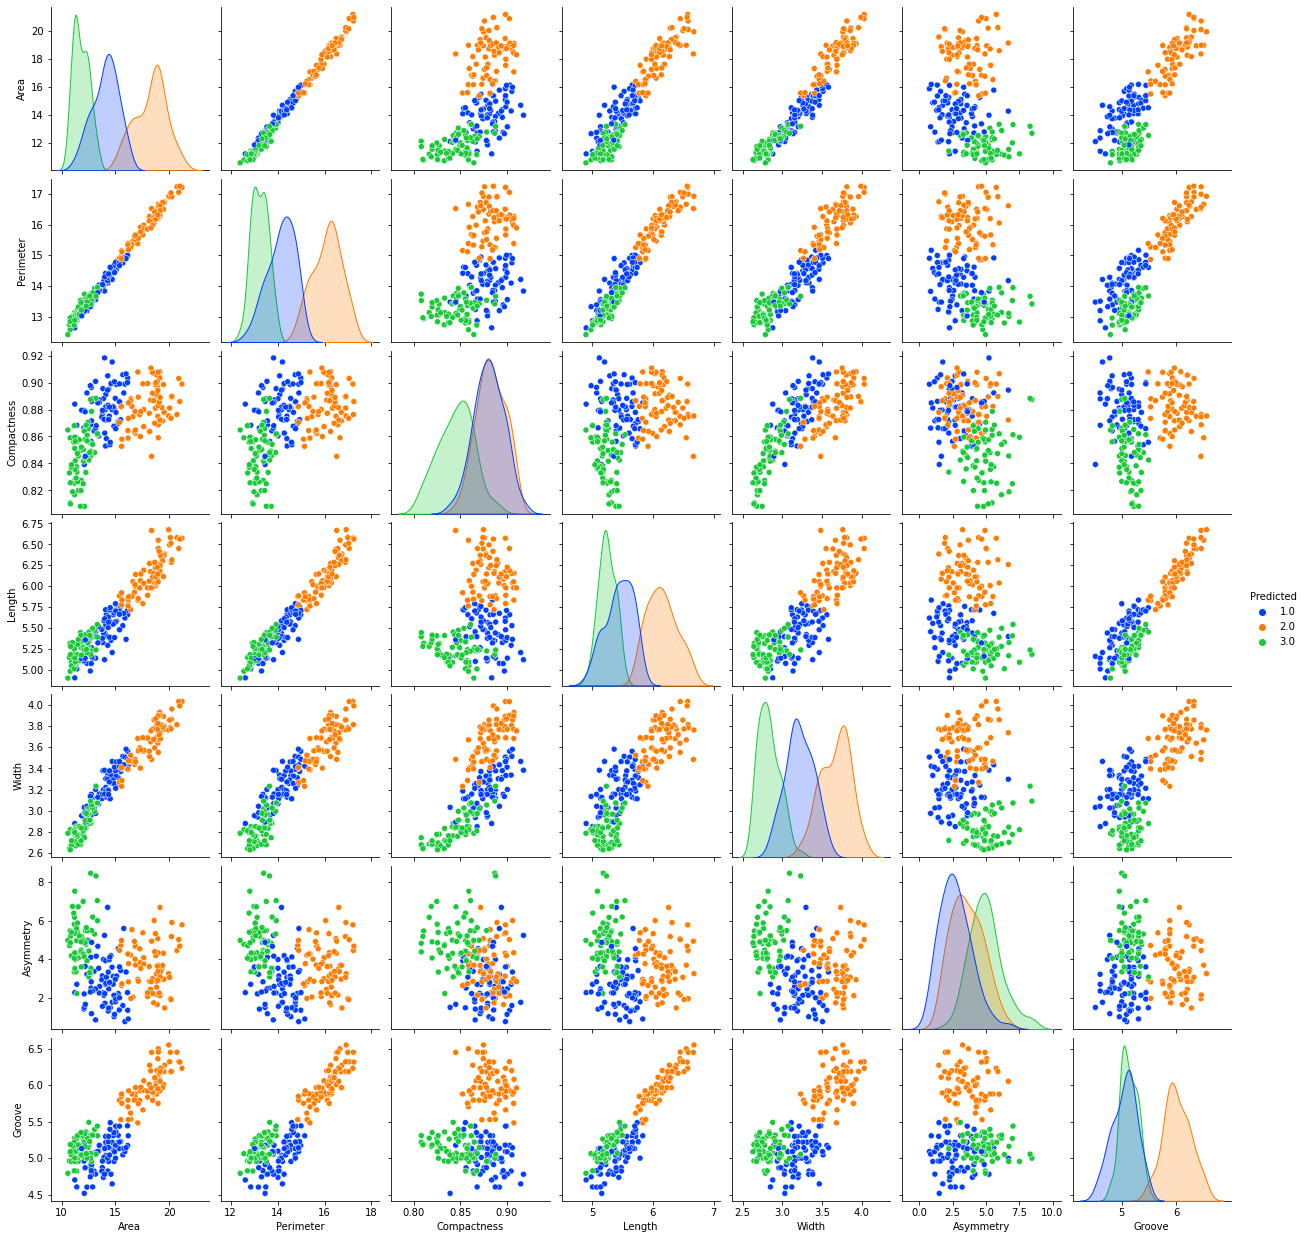

In [24]:
X_full['Predicted'] = ordered_pred_full
sns.pairplot(X_full, hue = 'Predicted', palette = 'bright')


[Text(0.5, 1.0, 'Predicted Groove v. Length')]

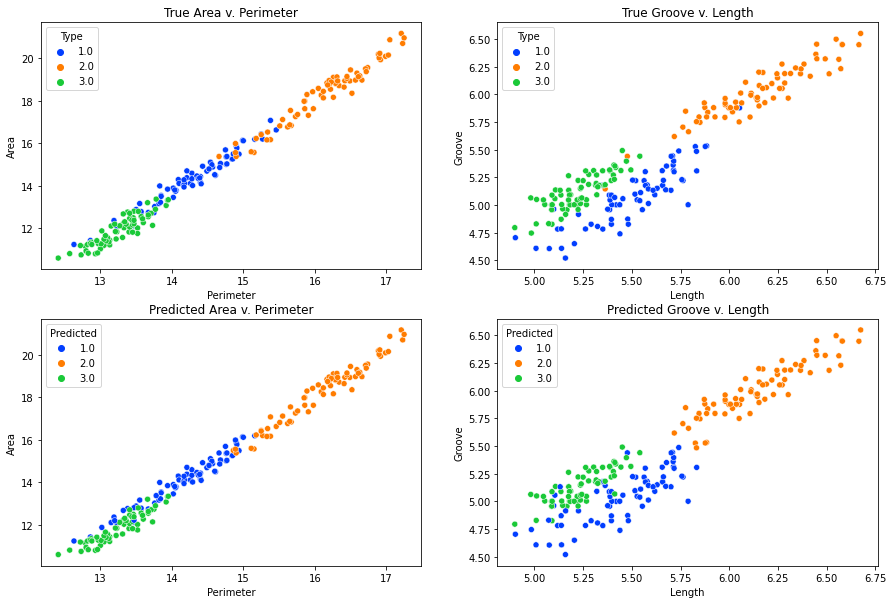

In [25]:
fig, axes = plt.subplots(2,2, figsize = (15,10))
sns.scatterplot(data = data, y = "Area", x = "Perimeter", hue = 'Type', palette = 'bright', ax = axes[0,0]).set(title = "True Area v. Perimeter")
sns.scatterplot(data = X_full, y = "Area", x = "Perimeter", hue = 'Predicted', palette = 'bright', ax = axes[1,0]).set(title = "Predicted Area v. Perimeter")

sns.scatterplot(data = data, y = "Groove", x = "Length", hue = 'Type', palette = 'bright', ax = axes[0,1]).set(title = "True Groove v. Length")
sns.scatterplot(data = X_full, y = "Groove", x = "Length", hue = 'Predicted', palette = 'bright', ax = axes[1,1]).set(title = "Predicted Groove v. Length")

# Comparison to Supervised Approach

In [26]:
X_test.drop('Predicted', axis = 1, inplace = True) #Since we added it for plotting, quickly drop it here.

C:\Users\Zade\anaconda3\envs\py38\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [27]:
#sklearn suggested linear SVC so we will explore that
with warnings.catch_warnings(): #many covergence warnings, ignore them for now
    warnings.simplefilter("ignore")
    SVCpipeline = Pipeline([('scale', StandardScaler()), ('SVC', LinearSVC(random_state = 54322))]) #set random state for reproduction if needed
    param_grid = {'SVC__C':np.arange(0.01, 100, 10)} #Could play around with L1/L2 penalties but only real combo is with squared hinge as l1/hinge is not supported. leave as is for now
    linSVC = GridSearchCV(SVCpipeline, param_grid, cv = 5, return_train_score = True)
    linSVC.fit(X_train, y_train)
    print(linSVC.best_params_)
    best_run = linSVC.best_estimator_
    best_run.fit(X_train, y_train)
    best_run.coef_ = best_run.named_steps['SVC'].coef_
    print(best_run.score(X_test, y_test))


{'SVC__C': 10.01}
0.9523809523809523


In [28]:
y_pred_sup = best_run.predict(X_test)
X_test['Supervised'] = y_pred_sup

<ipython-input-28-257d6fd0778d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Supervised'] = y_pred_sup


In [38]:
# ordered_pred_sup = predorder(y_pred_sup, y_test, 3)
print(f"highest acc score (supervised): {round(np.mean(y_pred_sup == y_test),4)}") #accuracy value
print(f"rand score (supervised): {round(rand_score(y_pred_sup, y_test), 4)}, adjusted rand score (supervised): {round(adjusted_rand_score(y_test, y_pred_sup),4)}")

highest acc score (supervised): 0.9524
rand score (supervised): 0.935, adjusted rand score (supervised): 0.851


[Text(0.5, 1.0, 'Supervised Groove v. Length')]

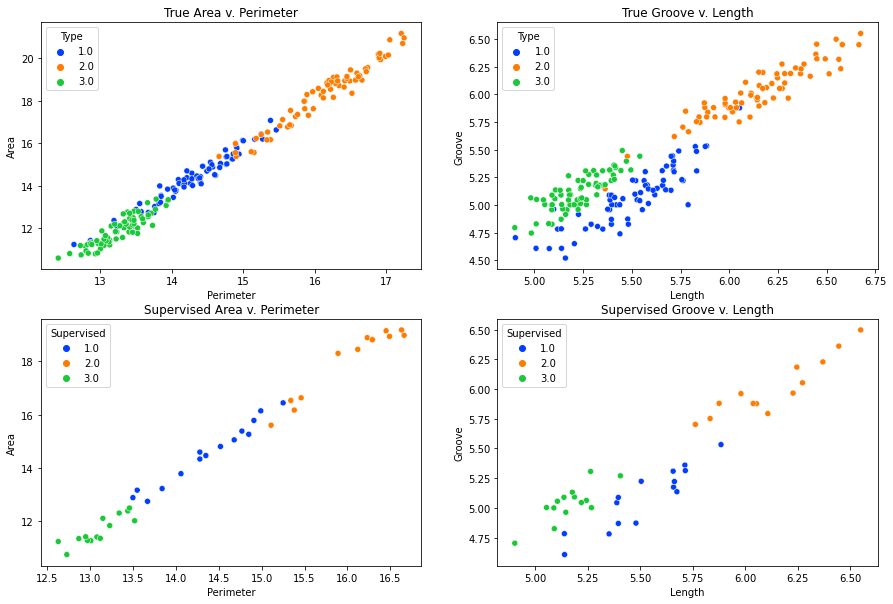

In [29]:
#same plots as before but now with our supervised results
fig, axes = plt.subplots(2,2, figsize = (15,10))
sns.scatterplot(data = data, y = "Area", x = "Perimeter", hue = 'Type', palette = 'bright', ax = axes[0,0]).set(title = "True Area v. Perimeter")
sns.scatterplot(data = X_test, y = "Area", x = "Perimeter", hue = 'Supervised', palette = 'bright', ax = axes[1,0]).set(title = "Supervised Area v. Perimeter")

sns.scatterplot(data = data, y = "Groove", x = "Length", hue = 'Type', palette = 'bright', ax = axes[0,1]).set(title = "True Groove v. Length")
sns.scatterplot(data = X_test, y = "Groove", x = "Length", hue = 'Supervised', palette = 'bright', ax = axes[1,1]).set(title = "Supervised Groove v. Length")

# Results and Conclusion

|      Metric       | Unsupervised (Split)        | Unsupervised (Full)        |    Supervised       |
| :-------:         | :-----------:               | :-----------:              | :---------:         |
|  Accuracy         | 0.9286                      | 0.9238                     |   0.9524            |
|  Rand Score       | 0.9036                      | 0.9053                     |   0.935             |
|  Adjusted Rand    | 0.7814                      | 0.7861                     |   0.851             |

We can see that our supervised approach is quite a bit better as compared to either of our unsupervised approaches when using the metric of the adjusted rand score (which seems the most applicable in this problem set).  Our unsupervised methods are similarly scored with a marginal improvement when we use the full as opposed to the split datasets.  This is expected given that we're only adding on 42 data points when we include the test set so we wouldn't expect to see too big of an improvement.  The large disparity between the rand and adjusted rand scores was unexpected given the low number of clusters, but it doesn't impact our conclusions much given that we will be using the adjusted rand as our primary metric anyways.  
Overall we can see that with an unsupervised approach we get quite good predictions even with our low sample size.  If we were to increase the sample size it seems that this methodology could be applicable to large-scale operations and the code above was written with an eye towards expansion in the sense that it was written to be largely agnostic of the true number of kernel types.  There will need to be some adjustment (e.g. reassment of the elbow graph to select k) should new kernel types be added in, but the code would largely run again without extra aid otherwise.  
An interesting thing to think about which we can not test immediately would be the possible increase in accuracy / rand score(s) from using a semi-supervised approach when including more data.  That is to say, how good would our metrics be should we utilize the supervised approach at first but then proceed with the unsupervised methodology when adding in new, unlabled data?  I believe that this would be, at the very least, a good avenue to approach the problem of scaling up with.

## Dataset citation:  
MaÅ‚gorzata Charytanowicz, Jerzy Niewczas
Institute of Mathematics and Computer Science,
The John Paul II Catholic University of Lublin, KonstantynÃ³w 1 H,
PL 20-708 Lublin, Poland
e-mail: {mchmat,jniewczas}@kul.lublin.pl

Piotr Kulczycki, Piotr A. Kowalski, Szymon Lukasik, Slawomir Zak
Department of Automatic Control and Information Technology,
Cracow University of Technology, Warszawska 24, PL 31-155 Cracow, Poland
and
Systems Research Institute, Polish Academy of Sciences, Newelska 6,
PL 01-447 Warsaw, Poland
e-mail: {kulczycki,pakowal,slukasik,slzak}@ibspan.waw.pl